In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from gpytorch.priors import NormalPrior
from grakel.kernels import WeisfeilerLehman

from mobius import Planner, SequenceGA
from mobius import Graph, GPGKModel, ExpectedImprovement
from mobius import LinearPeptideEmulator
from mobius import homolog_scanning, alanine_scanning
from mobius import convert_FASTA_to_HELM

# Initialize MHC emulator

In [3]:
pssm_files = ['../data/IEDB_MHC_I-2.9_matx_smm_smmpmbec/smmpmbec_matrix/HLA-A-02:01-8.txt',
              '../data/IEDB_MHC_I-2.9_matx_smm_smmpmbec/smmpmbec_matrix/HLA-A-02:01-9.txt',
              '../data/IEDB_MHC_I-2.9_matx_smm_smmpmbec/smmpmbec_matrix/HLA-A-02:01-10.txt',
              '../data/IEDB_MHC_I-2.9_matx_smm_smmpmbec/smmpmbec_matrix/HLA-A-02:01-11.txt']
lpe = LinearPeptideEmulator(pssm_files)

# Define lead peptide and create initial peptide batch

In [4]:
lead_peptide = convert_FASTA_to_HELM('HMTEVVRRC')[0]

In [5]:
seed_library = [lead_peptide]

for seq in alanine_scanning(lead_peptide):
    seed_library.append(seq)

for seq in homolog_scanning(lead_peptide):
    seed_library.append(seq)

    if len(seed_library) >= 96:
        print('Reach max. number of peptides allowed.')
        break

Reach max. number of peptides allowed.


In [6]:
pic50_seed_library = lpe.score(seed_library)

# Define Gaussian Process, acquisition function and GA optimizer

In [25]:
graph_convertor = Graph(input_type='helm', output_type='grakel')
kernel = WeisfeilerLehman(normalize=True)
gpmodel = GPGKModel(kernel=kernel, transform=graph_convertor, noise_prior=NormalPrior(loc=0, scale=1))

In [26]:
yaml_content = """
design:
  monomers:
    default: [A, C, D, E, F, G, H, I, K, L, M, N, P, Q, R, S, T, V, W, Y]
    APOLAR: [A, F, G, I, L, P, V, W]
    POLAR: [C, D, E, H, K, N, Q, R, K, S, T, M]
    AROMATIC: [F, H, W, Y]
    POS_CHARGED: [K, R]
    NEG_CHARGED: [D, E]
  polymers:
    - PEPTIDE1{X.M.X.X.X.X.X.X.X}$$$$V2.0:
        PEPTIDE1:
          1: [AROMATIC, NEG_CHARGED]
          4: POLAR
          9: [A, V, I, L, M, T]
filters:
  - class_path: mobius.PeptideSelfAggregationFilter
  - class_path: mobius.PeptideSolubilityFilter
    init_args:
      hydrophobe_ratio: 0.5
      charged_per_amino_acids: 5
"""

with open('design_protocol.yaml', 'w') as f:
    f.write(yaml_content)

In [27]:
ei = ExpectedImprovement(gpmodel, maximize=False)
optimizer = SequenceGA(algorithm='GA', period=15, n_pop=500, design_protocol_filename='design_protocol.yaml')
ps = Planner(ei, optimizer)

# Run optimization!

In [28]:
peptides = seed_library.copy()
pic50_scores = pic50_seed_library.copy()

# Store data for later analysis
data = [(0, p, s) for p, s in zip(peptides, pic50_scores)]

for i in range(3):
    suggested_peptides, _ = ps.recommend(peptides, pic50_scores.reshape(-1, 1), batch_size=96)

    # Here you can add whatever methods you want to further filter out peptides

    # Virtually test the suggested peptides using the MHC emulator
    # You know the drill now, this is for benchmarking or demonstration
    # purposes only and should be replaced with actual lab experiments.
    pic50_suggested_peptides = lpe.score(suggested_peptides)

    peptides = np.concatenate([peptides, suggested_peptides])
    pic50_scores = np.concatenate((pic50_scores, pic50_suggested_peptides), axis=0)
    data.extend([(i + 1, p, s) for p, s in zip(suggested_peptides, pic50_suggested_peptides)])

    best_seq = peptides[np.argmin(pic50_scores)]
    best_pic50 = np.min(pic50_scores)
    print('Best peptide found so far: %s / %.3f' % (best_seq, best_pic50))
    print('')

df = pd.DataFrame(data=data, columns=('iter', 'polymer', 'exp_value'))

n_gen  |  n_eval  |     cv_min    |     cv_avg    |        f_avg         |        f_min         |              best sequence              
     1 |        0 |  0.000000E+00 |  0.1265822785 |  9.54677304347826094 |  8.42586000000000013 |      PEPTIDE1{H.M.T.E.V.V.R.R.L}$$$$V2.0
     2 |      500 |  0.000000E+00 |  0.0300000000 |  1.10595906035527336 | -2.3548296042762E+00 |      PEPTIDE1{F.M.F.E.V.V.L.R.V}$$$$V2.0
     3 |     1000 |  0.000000E+00 |  0.000000E+00 | -6.6635753721825E-01 | -3.0112562124721E+00 |      PEPTIDE1{D.M.L.E.I.V.P.M.L}$$$$V2.0
     4 |     1500 |  0.000000E+00 |  0.000000E+00 | -1.1624028622028E+00 | -3.0112562124721E+00 |      PEPTIDE1{D.M.L.E.I.V.P.M.L}$$$$V2.0
     5 |     2000 |  0.000000E+00 |  0.000000E+00 | -1.6662029247080E+00 | -3.4869005648600E+00 |      PEPTIDE1{E.M.T.D.M.L.D.M.V}$$$$V2.0
     6 |     2500 |  0.000000E+00 |  0.000000E+00 | -2.1199789565477E+00 | -3.5927140513350E+00 |      PEPTIDE1{E.M.M.E.E.L.D.M.V}$$$$V2.0
     7 |     3000 |  0.0000

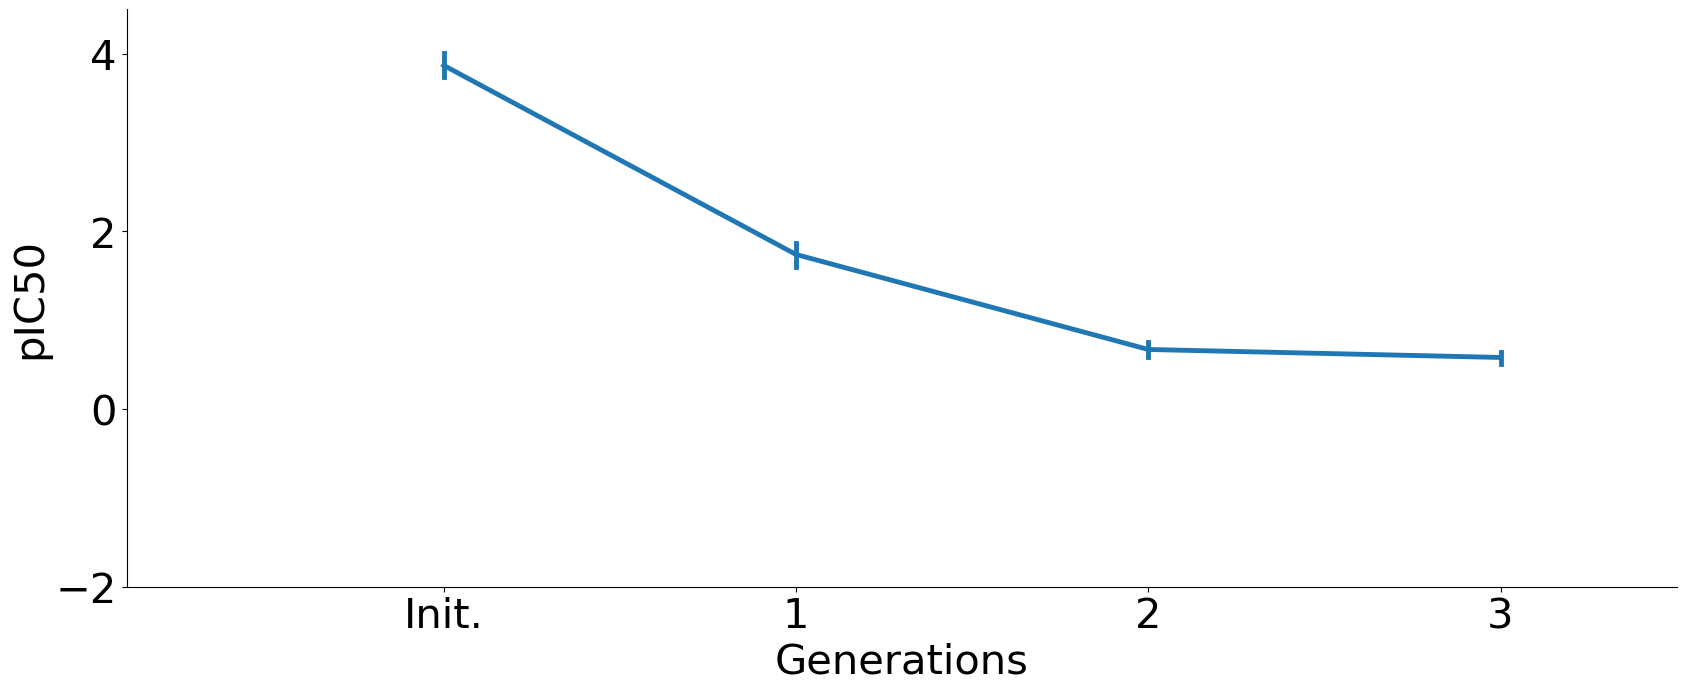

In [29]:
fig, ax = plt.subplots(figsize=(20, 7.5))

# pandas dataframe (df) columns: iter, peptide, exp_value
df['iter'] = df['iter'].replace({0: 'Init.', 1: '1', 2: '2', 3: '3'})

sns.lineplot(x='iter', y='exp_value', data=df, ax=ax, errorbar=('ci', 95), err_style='bars', linewidth=3.5, err_kws={'lw': 3.5})

ax.set_xlim([-0.9, 3.5])
ax.set_ylim([-2, 4.5])
ax.set_ylabel('pIC50', fontsize=30)
ax.set_xlabel('Generations', fontsize=30)
ax.xaxis.set_tick_params(labelsize=30)
ax.yaxis.set_tick_params(labelsize=30)

sns.despine()
plt.show()